### Imports

In [77]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

# Future libraries:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

### Data collection

#### Assume our data is stored as a CSV and we have time stamps

In [78]:
file = 'sensor_data.csv'
df = pd.read_csv(file)

### Cleaning Data

#### For now I am going to assume the data is in perfect shape. Once we actually get real data I am going to modify this

In [79]:
df.drop(['GasSensor', 'IRCameraPixels'], axis=1, inplace=True)
features = df.columns


### Exploratory Data Analysis

In [80]:
df.head()

,Timestamp,Temperature,Pressure,Humidity,BatteryCharge,NetCurrent,Tension,BatteryTemp,PM1.0,PM2.5,...,PM10.0,PM1.0_1/cm3,PM2.5_1/cm3,PM4.0_1/cm3,PM10.0_1/cm3,PMTypSize,CO2,StationID,MsgCounter,PacktCheckSum
0,2022-01-01 00:00:00,21.871135,104515.177509,65.520433,83.117207,-1.128363,3.817853,22.122549,44.667148,21.878068,...,137.148746,157.527326,734.787318,2467.477130,629.656802,7.553400,418.796358,1,92,125
1,2022-01-01 00:05:00,26.149622,103484.731233,25.854750,83.784752,0.803510,3.868300,20.332644,30.571540,87.128764,...,185.329882,533.221002,325.010312,617.796451,1235.367342,4.967621,483.921372,9,50,68
2,2022-01-01 00:10:00,28.888988,96721.567755,22.414686,96.160295,0.797381,4.095355,23.723969,5.785665,5.297177,...,156.826452,164.775887,502.931941,2597.122817,2812.025931,5.935501,371.383474,9,6,199
3,2022-01-01 00:15:00,21.338502,93395.538795,65.194185,85.216622,-0.507754,4.152125,32.558367,25.546529,78.219509,...,145.575524,429.491679,429.467005,1493.276817,2603.220970,8.989482,439.027595,4,30,72
4,2022-01-01 00:20:00,28.906791,101615.221839,45.521316,95.984542,-0.113942,4.150757,36.040230,24.862716,61.581890,...,82.812388,408.712523,1463.320039,1098.460388,364.158677,1.980996,429.733094,8,74,197


In [81]:
df.tail()

,Timestamp,Temperature,Pressure,Humidity,BatteryCharge,NetCurrent,Tension,BatteryTemp,PM1.0,PM2.5,...,PM10.0,PM1.0_1/cm3,PM2.5_1/cm3,PM4.0_1/cm3,PM10.0_1/cm3,PMTypSize,CO2,StationID,MsgCounter,PacktCheckSum
995,2022-01-04 10:55:00,19.745294,93509.099404,21.040756,94.688946,0.105318,4.193487,21.126580,37.729860,94.536797,...,144.368550,199.630649,1895.575030,121.166973,3675.658388,5.014374,401.455953,4,98,141
996,2022-01-04 11:00:00,23.298298,106124.193103,79.639864,90.020411,-0.400610,4.117324,35.713555,34.444655,72.941999,...,46.819584,268.706620,32.735528,1690.548058,2401.863253,3.739350,310.321671,9,10,38
997,2022-01-04 11:05:00,23.871387,107768.634103,52.612414,92.087229,0.228102,4.024710,32.197990,6.660930,55.814273,...,194.994913,439.963150,1648.198579,365.015679,2926.451277,2.237640,364.243260,7,88,1
998,2022-01-04 11:10:00,27.278235,107025.776786,48.417845,86.055472,-0.201025,3.876142,21.290897,25.103229,59.068615,...,132.959398,446.128009,338.275187,945.626978,226.363390,5.574117,424.120536,1,89,61
999,2022-01-04 11:15:00,21.033894,98667.338974,77.277042,84.007206,0.372593,3.823442,24.363212,39.040732,53.899201,...,90.485377,774.411712,784.440457,1984.880585,2241.021820,8.894923,468.211387,6,48,52


In [82]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Temperature,1000.0,24.962677,4.802120,5.387999,21.741250,25.058604,28.093162,39.570546
Pressure,1000.0,99882.328134,5819.288828,90026.672790,94868.658747,99666.338090,105094.896478,109966.063115
Humidity,1000.0,49.985628,17.385288,20.079192,34.542572,49.779611,65.729726,79.988309
BatteryCharge,1000.0,90.070350,5.849052,80.006195,85.037346,90.115871,95.195068,99.998497
NetCurrent,1000.0,0.014147,0.511308,-1.541281,-0.336607,0.032131,0.361070,1.714455
Tension,1000.0,3.855940,0.199038,3.500870,3.688469,3.860045,4.021928,4.199260
BatteryTemp,1000.0,25.050224,5.113342,6.823999,21.753414,25.092940,28.418395,40.702115
PM1.0,1000.0,25.427672,14.334648,0.126088,13.550406,25.110206,38.264855,49.867227
PM2.5,1000.0,50.716258,29.722857,0.249545,24.395091,52.743225,76.189691,99.990098
PM4.0,1000.0,79.028238,43.480751,0.007219,42.352885,80.783542,116.357282,149.948446


In [ ]:
def create_dict():
    
    

In [85]:
# Expected that values contains the values you want to compare w.r.t time
# Time is every 5 minute intervals
def plot_time_series(timestamps, values, y_label = '', title='', width=0.5, start=100, end=200):
    
    # Extract time stamps
    times = pd.to_datetime(timestamps[start:end])
    values = values[start:end]
    # Plot the original series
    plt.figure(figsize=(12, 6))
    plt.plot(times, values, color='blue', label=y_label, linewidth=width)

    plt.title(title)
    plt.xlabel('Time[min]')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

In [86]:
features

Index(['Timestamp', 'Temperature', 'Pressure', 'Humidity', 'BatteryCharge',
       'NetCurrent', 'Tension', 'BatteryTemp', 'PM1.0', 'PM2.5', 'PM4.0',
       'PM10.0', 'PM1.0_1/cm3', 'PM2.5_1/cm3', 'PM4.0_1/cm3', 'PM10.0_1/cm3',
       'PMTypSize', 'CO2', 'StationID', 'MsgCounter', 'PacktCheckSum'],
      dtype='object')

# <b> CHANGE THE FORMAT SO THAT TIME IS CLOSER TOGETHER. DO DATA COLLECTION EVERY 10 SECONDS OR SMTH for now </b>

In [97]:
def display_time_series(start, end):
    for feature in features[1:]:
        plot_time_series(df.Timestamp, df[feature], y_label=feature, title= f'{feature} vs Time')

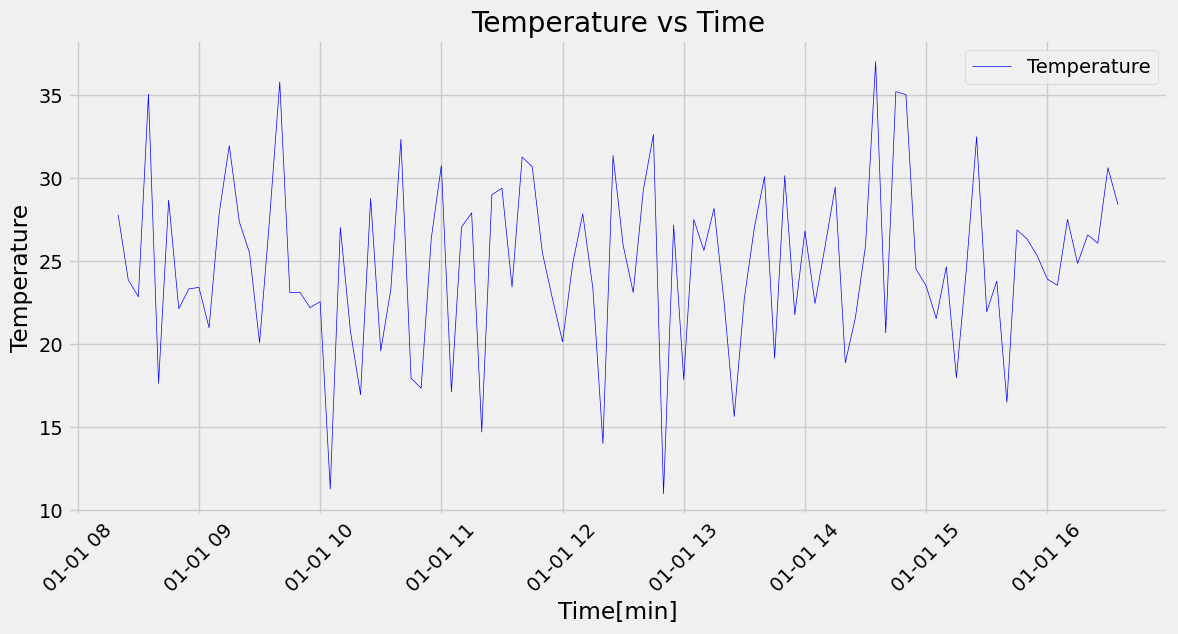

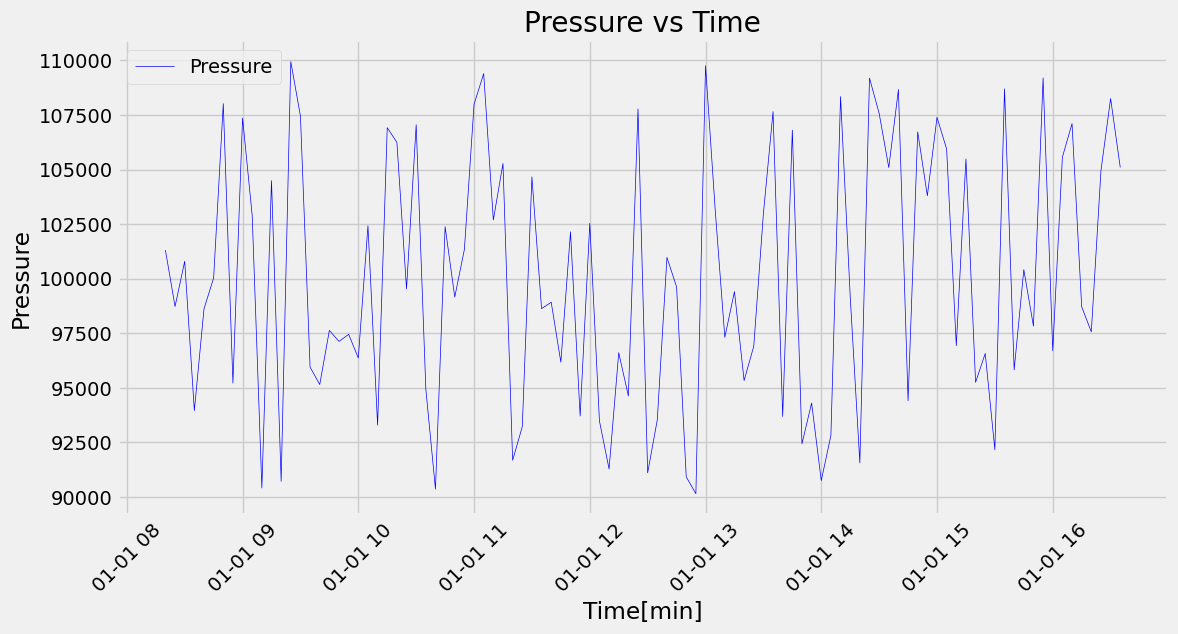

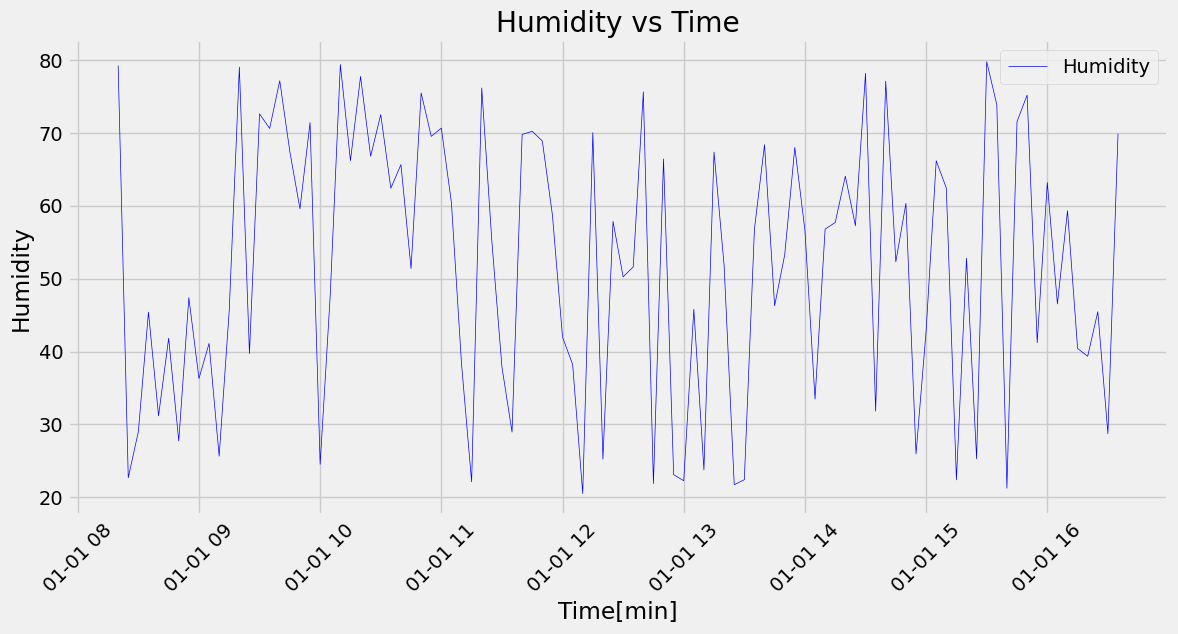

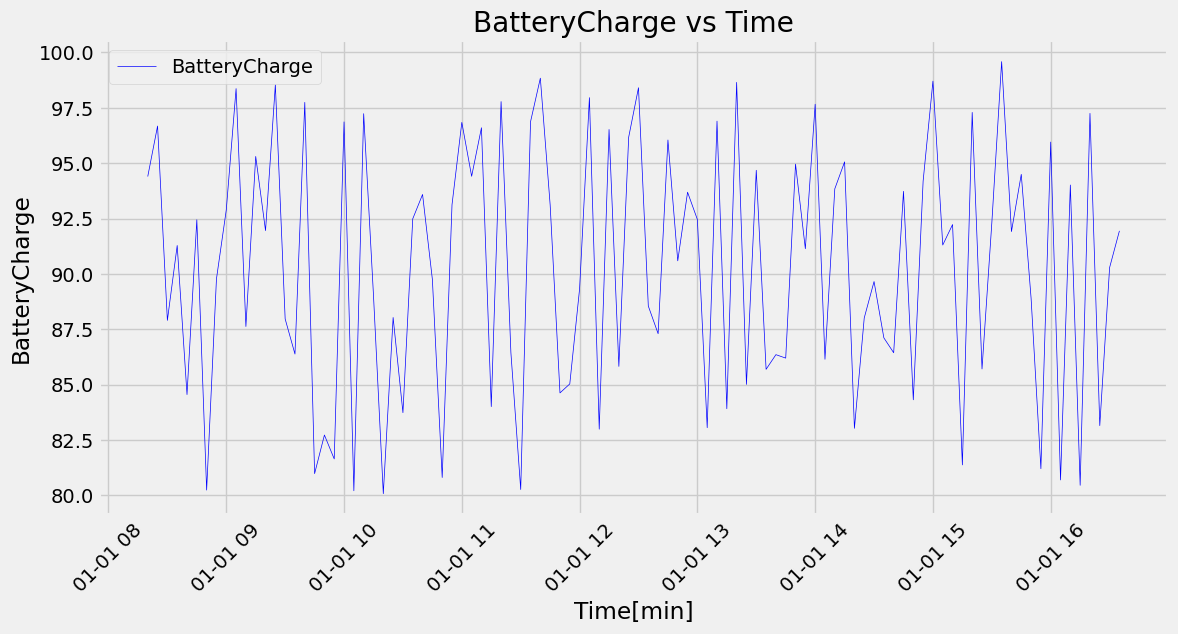

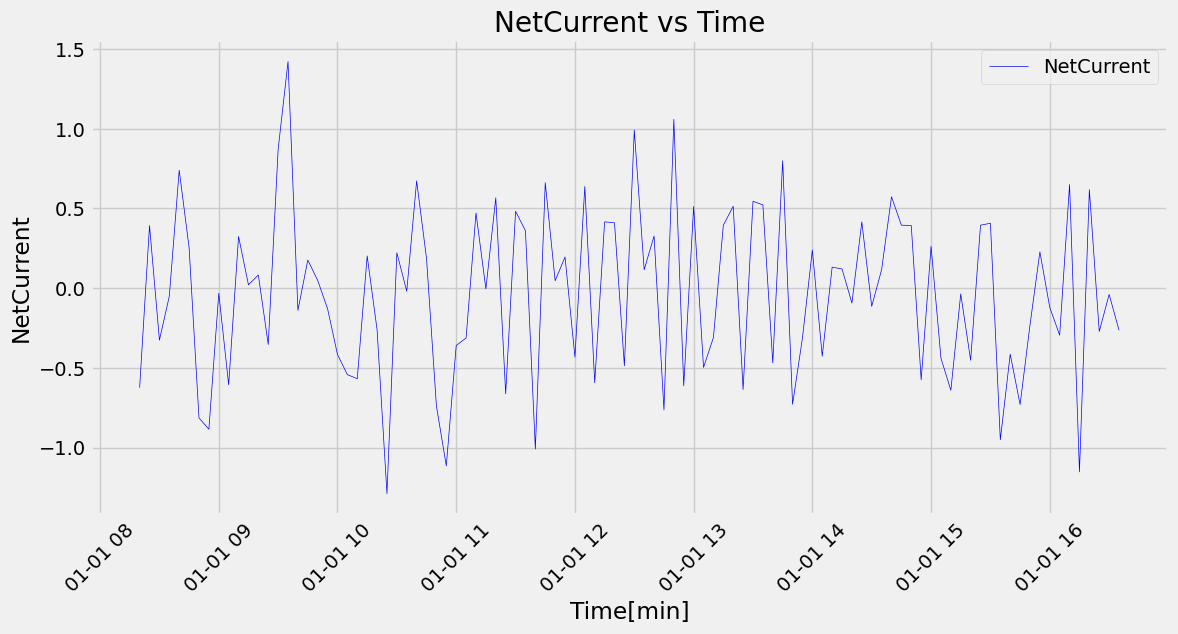

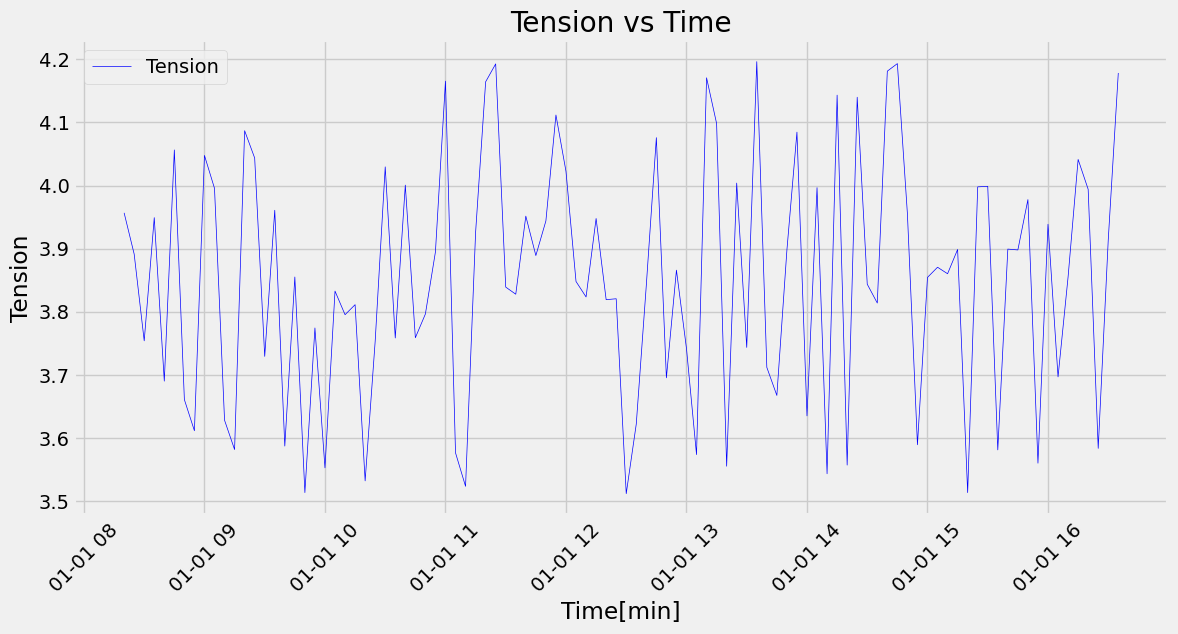

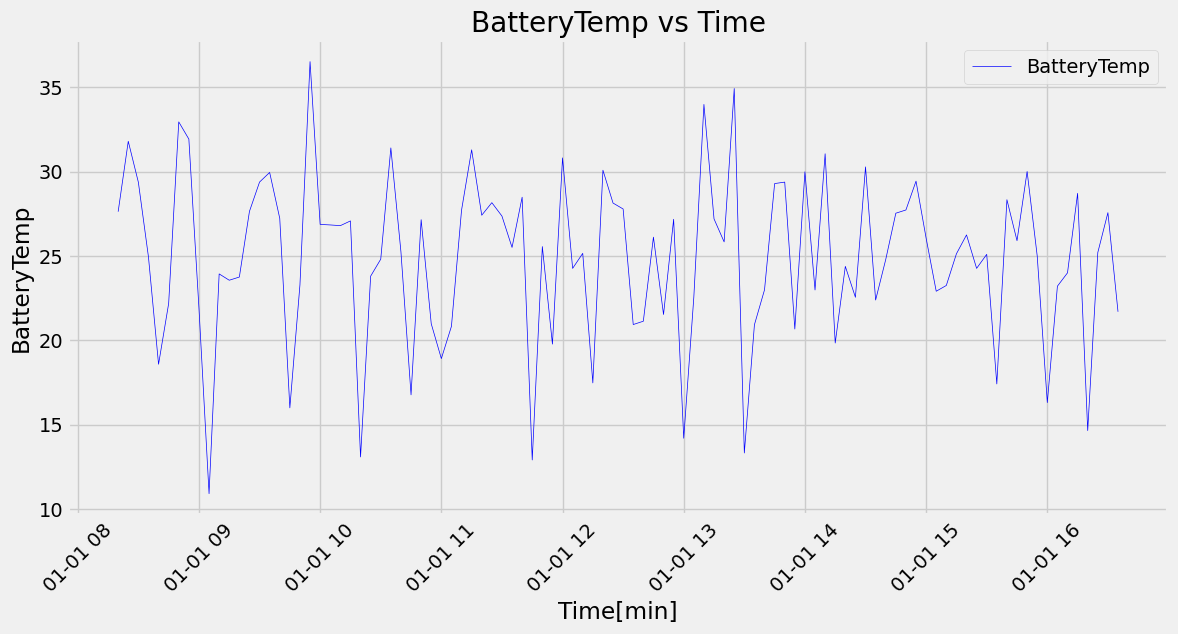

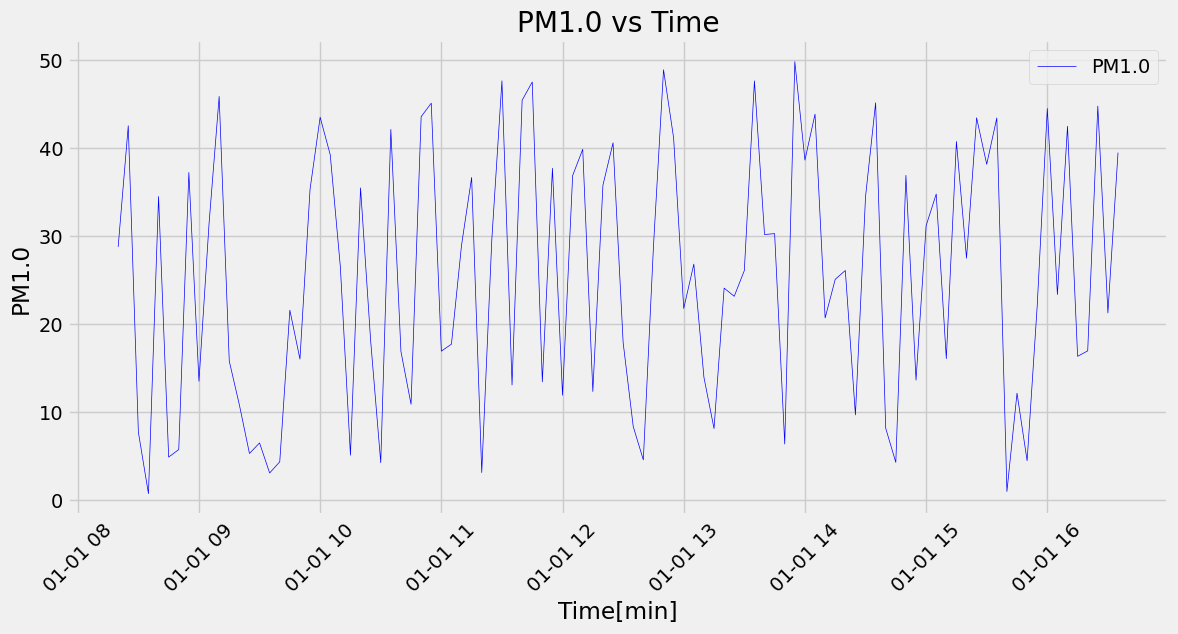

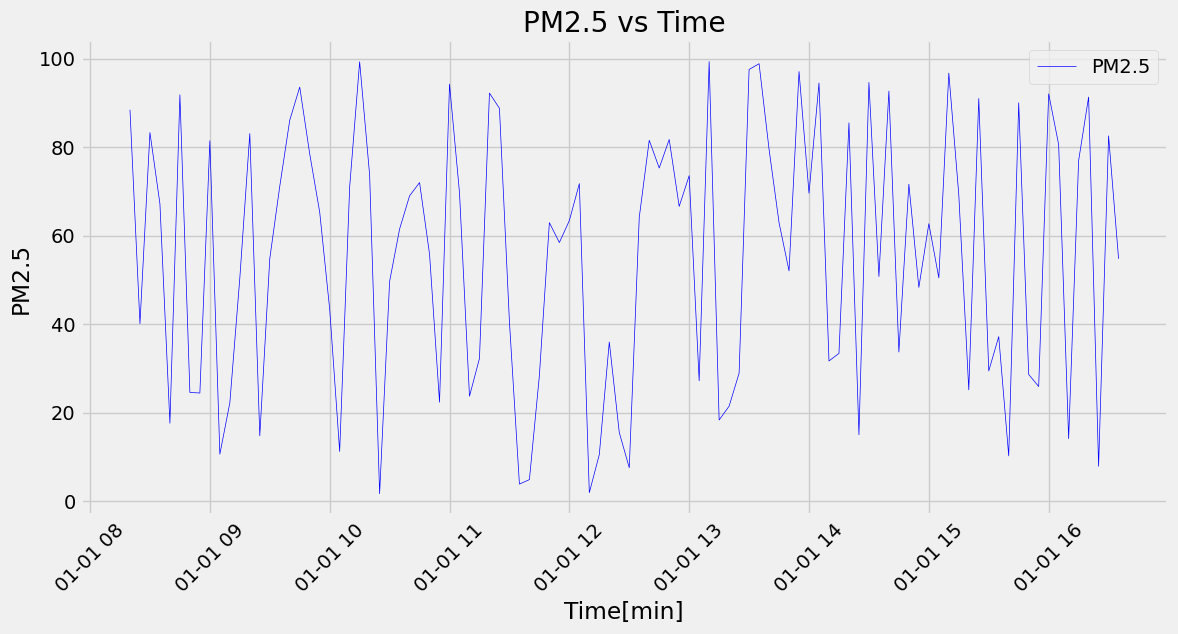

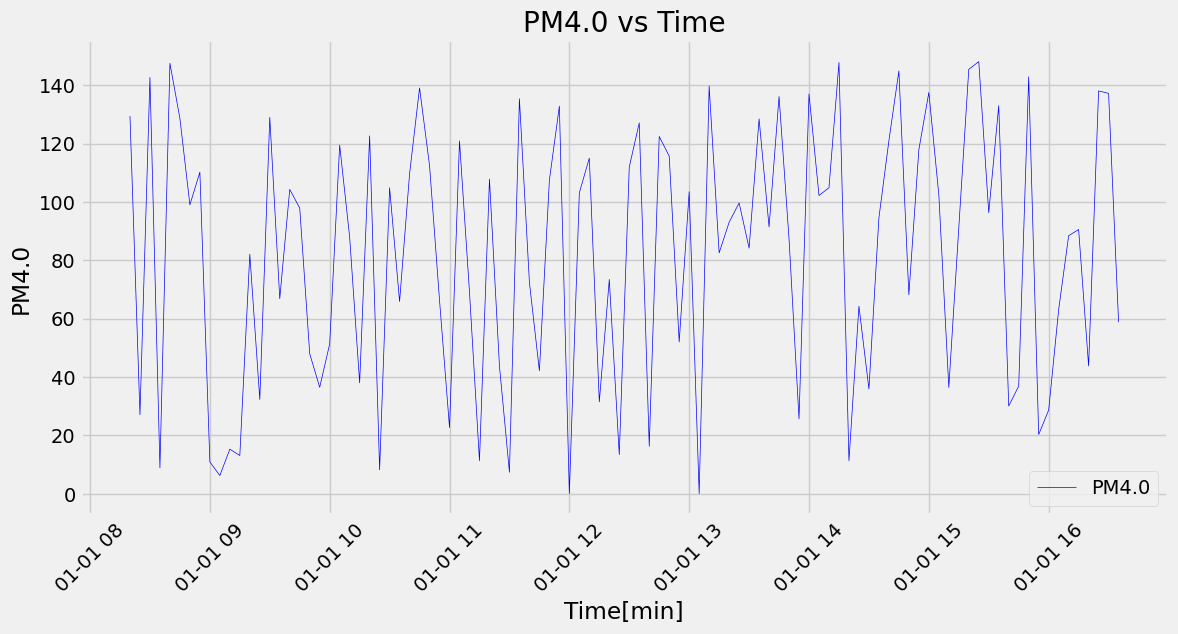

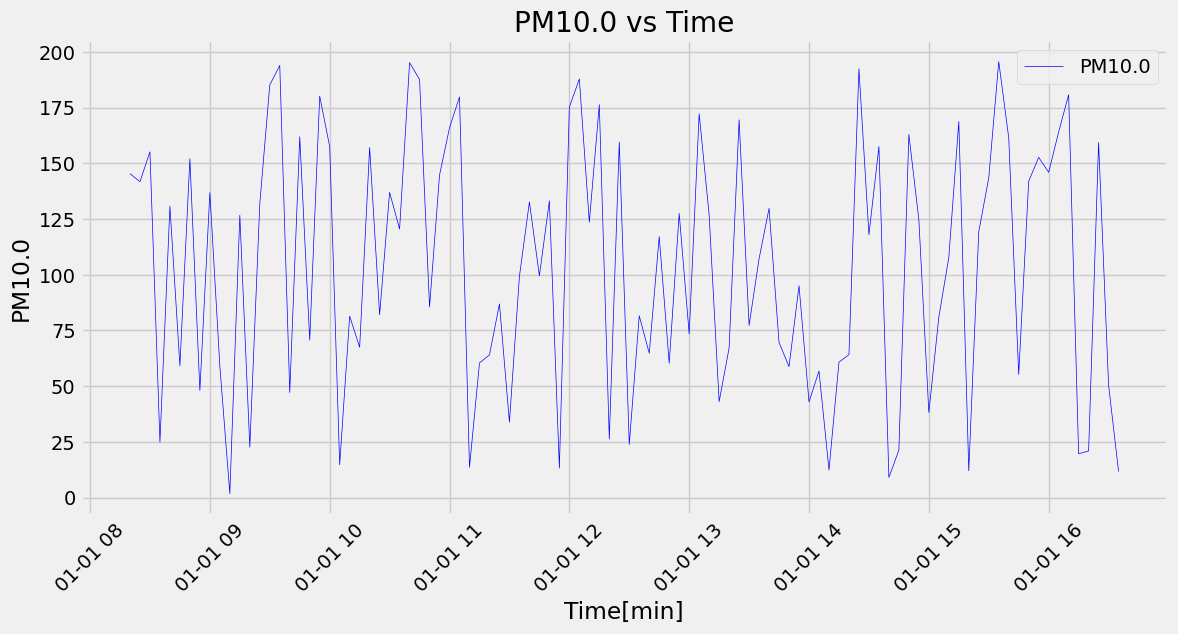

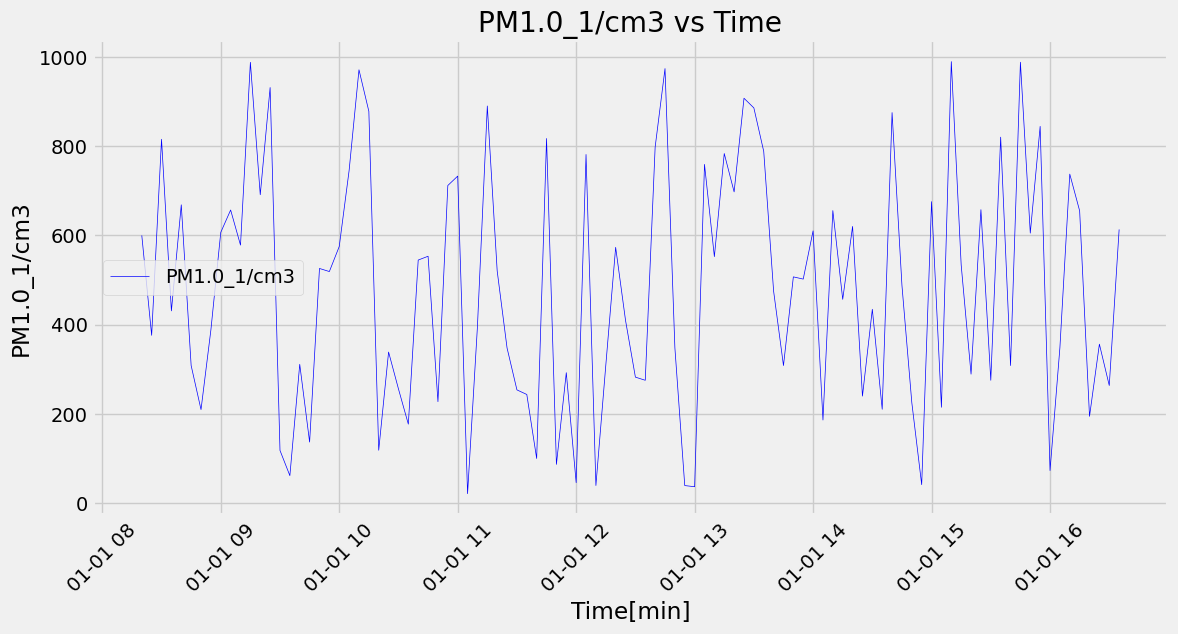

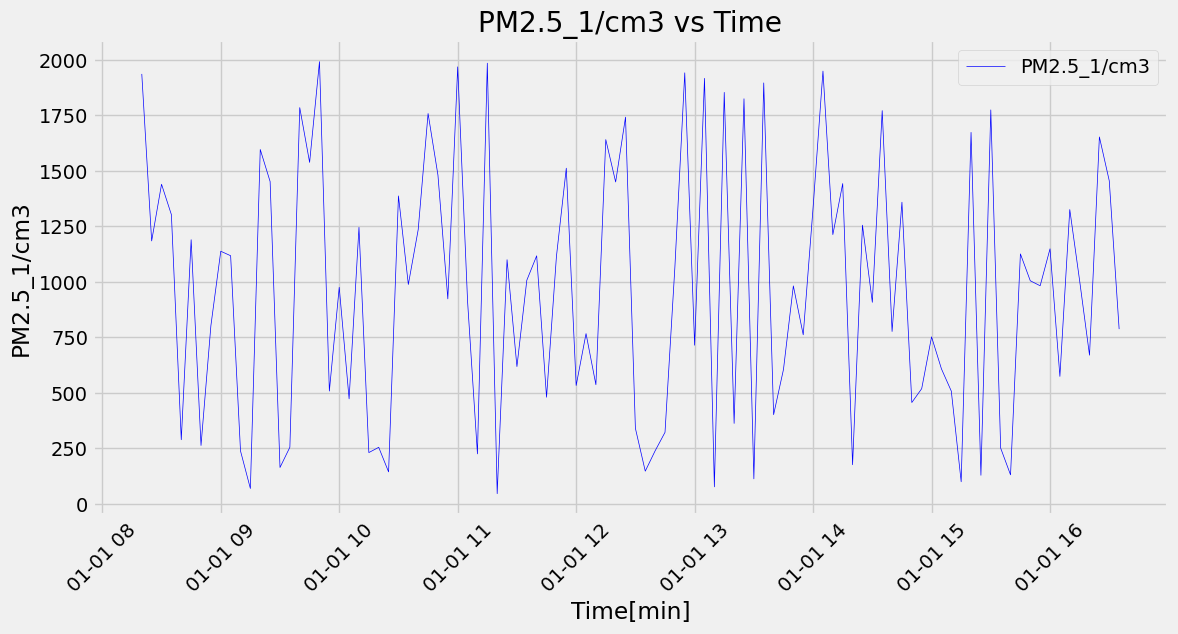

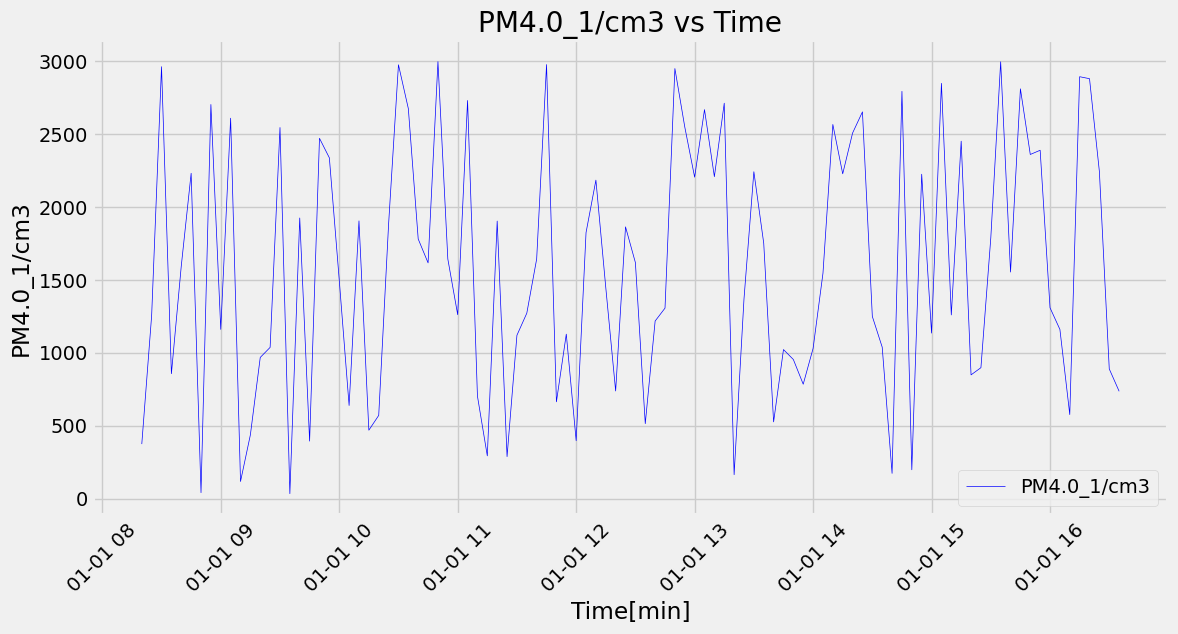

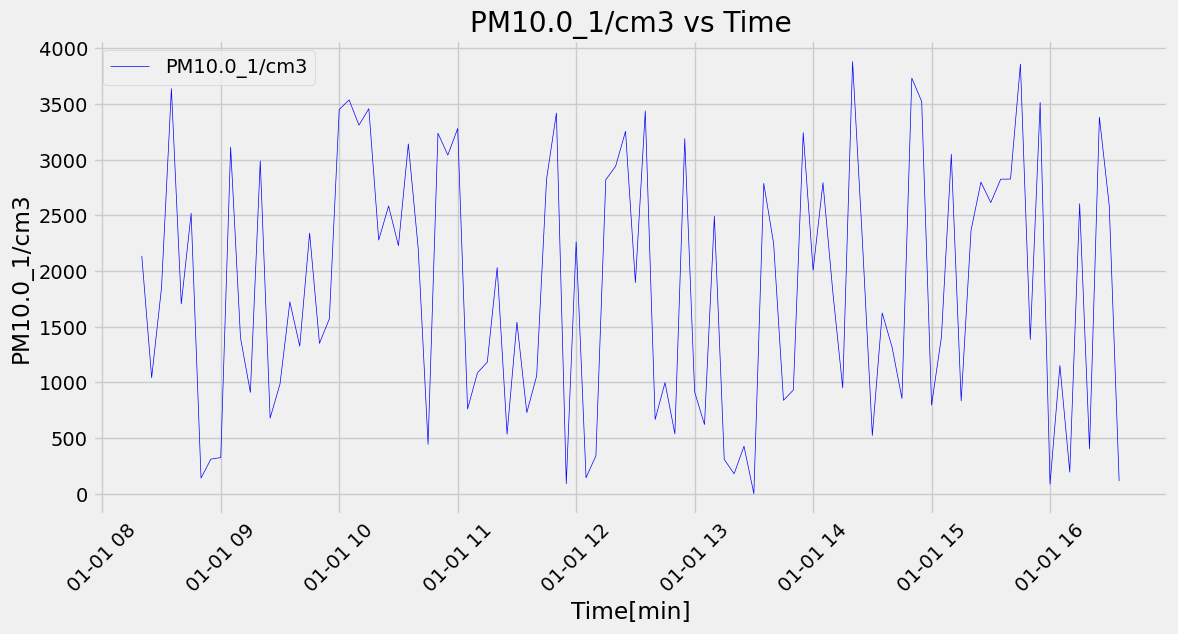

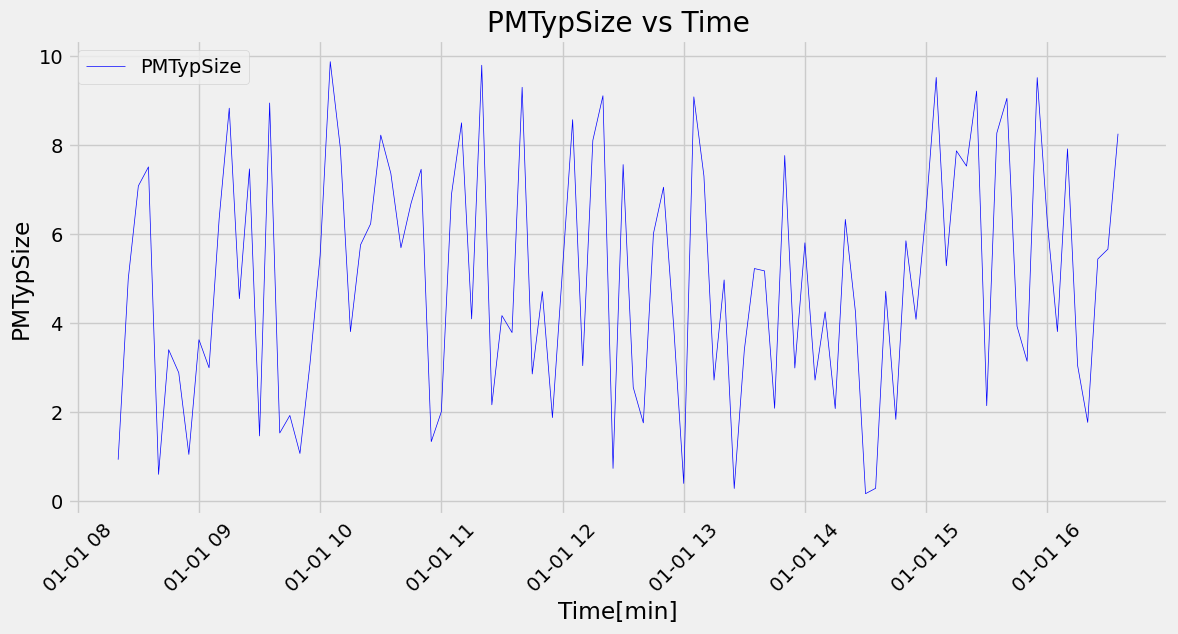

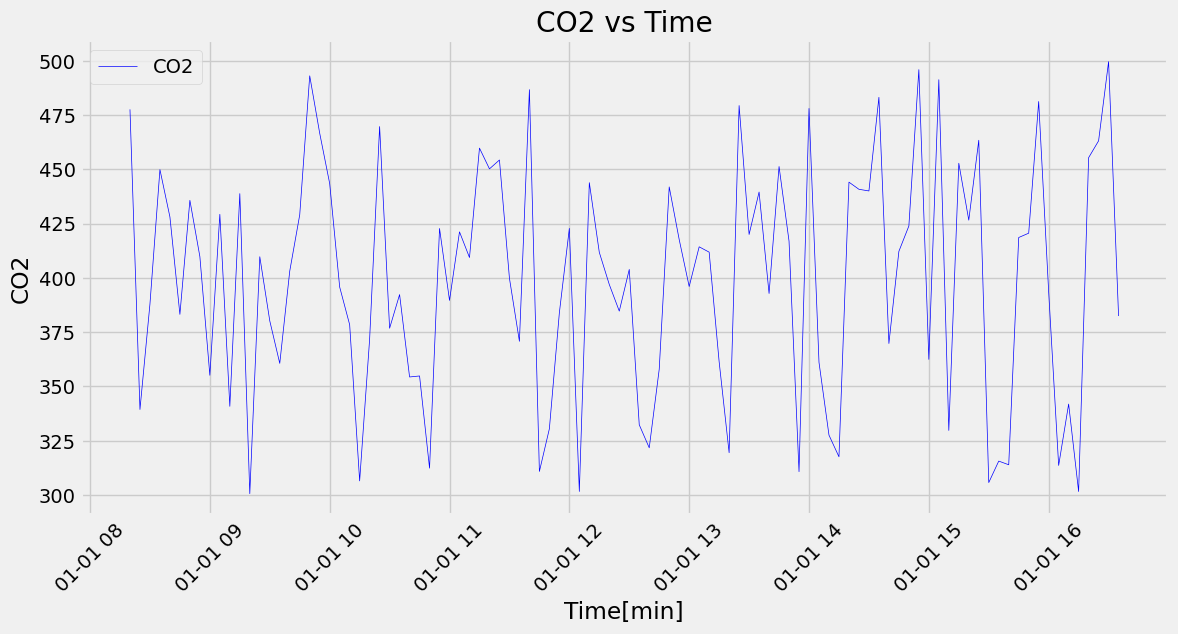

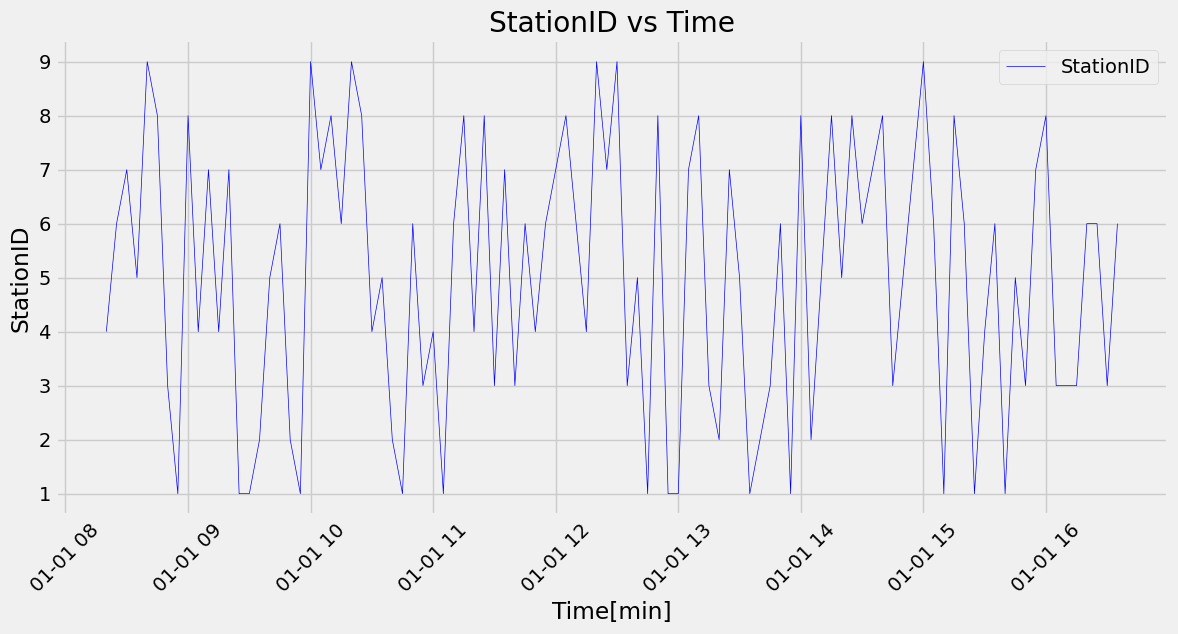

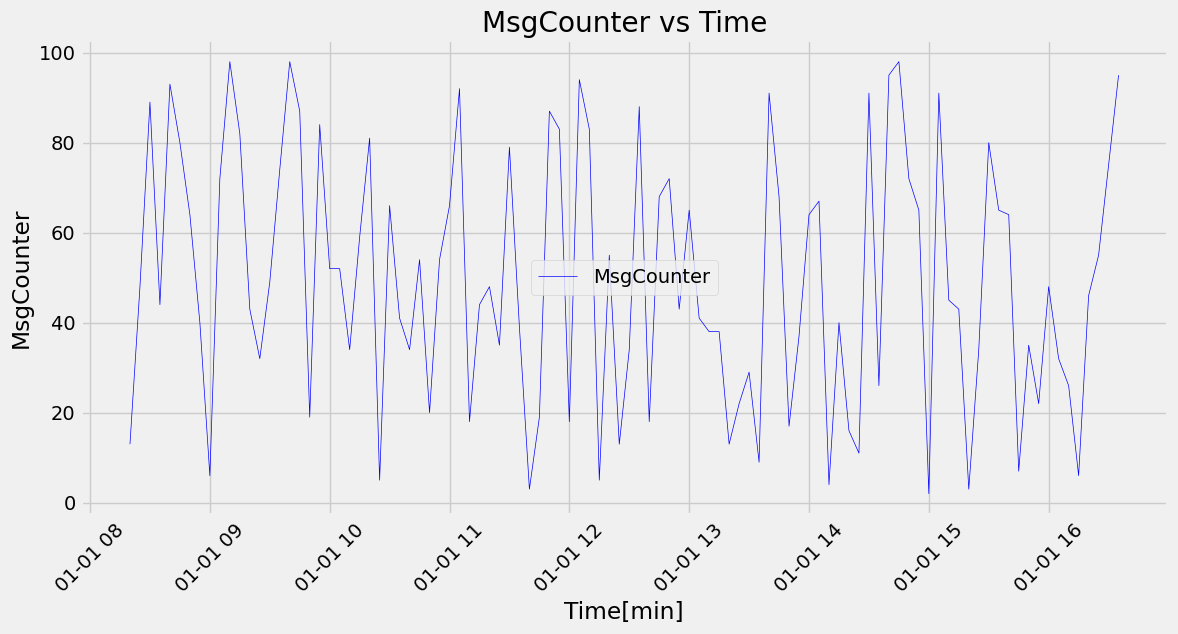

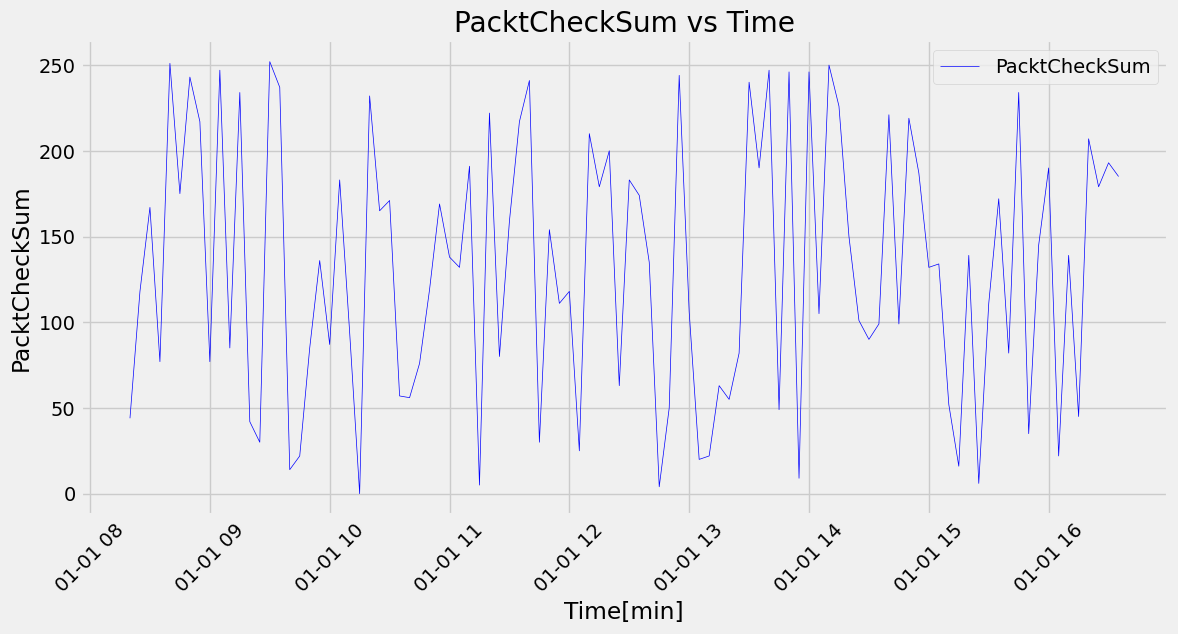

In [99]:
display_time_series(0, 30)